**In this notebook, we are not using the "Term" feature which is the most important feature based on the initial analysis with simpler models. The reason is to avoid the model to be more dependent on this feature and not learn the others. I will add the "Term" feature at the end to find the overall progress with and without this feature.**

The notebook includes the following tasks:

- Clean up the data:
    - Encode replace missing values
    - Replace features values that appear incorrect
- Encode categorical variables
- Split dataset to Train/Test/Validation
- Add engineered features
- Train and tune ML model (LightGBM Gradient Boosting / DART (dropout additive regression trees))
- Explain and interpret model results, feature importances, contirbutions (Permutation importance, Shap contribution)
- Residual analysis
- Provide final metrics using Validation dataset

 Deliverables are the same as the deliverables of the first model.

Overall Performance: F1 score of 0.95 (0.1 imporvement from the baseline models).


# load Packages

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np

import sklearn
from sklearn.model_selection import GridSearchCV
!pip install category_encoders
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


!pip install lightgbm
import lightgbm as lgbm

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

# Load and Feature Engineer

**Create cleaning and feature engineering functions**

In [ ]:
def clean_data(data):
    value_to_fill={}
    for col in data.columns:
        if data[col].dtype=='object':
            value_to_fill[col]='Missing'
        else:
            value_to_fill[col]=0
    data.fillna(value=value_to_fill,inplace=True)

    Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

    for col in Columns:
        for char in ['$',',']:
            data[col] = data[col].str.replace(char,'')
        data[col]=data[col].astype(float)

    #LowDoc and RevLineCr can only be 'Y' or 'N', i.e., yes or no.
    for col in ['LowDoc' , 'RevLineCr']:
        data[col]=data[col].agg(lambda x: 'Missing' if x not in ['N','Y'] else x)

    # NAICS code must be 6 digit code: replace smaller digits with 0.
    data['NAICS']=data['NAICS'].agg(lambda x: x if len(str(x))==6 else 0)

    # Franchise code 0 and 1 means 'NO Franchise'
    data['FranchiseCode']=data['FranchiseCode'].agg(lambda x: 1 if x==1 else x)
    
    # Convert NAICS, FranchaiseCode, Zip,'NewExist' and 'UrbanRural' into object type
    for col in ['FranchiseCode','NAICS','Zip','NewExist','UrbanRural']:
        data[col]=data[col].astype(object)

    #Convert MIS into binary
    MIS_dict={'P I F': 0, 'CHGOFF': 1, 'Missing':0}
    data['MIS_Status'].replace(MIS_dict,inplace=True)
    return(data)

def feature_engineer(data):
    ''' Creates two new features: Industry and Montly_disumbersement.
        Input: Cleaned SBA Dataframe
        Output: Dataframe with feature engineered columns
    '''
    industry_codes=['11','21','22','23','31','32','33','42','44','45','48','49','51',
                    '52','53','54','55','56','61','62','71','72','81','0']
    industry_dict={'11':'Agriculture, forestry, fishing and hunting',
        '21':'Mining, quarrying, and oil and gas extraction',
        '22':'Utilities',
        '23':'Construction',
        '31':'Manufacturing',
        '32':'Manufacturing',
        '33':'Manufacturing',
        '42':'Wholesale trade',
        '44':'Retail trade',
        '45':'Retail trade',
        '48':'Transportation and warehousing',
        '49':'Transportation and warehousing',
        '51':'Information',
        '52':'Finance and insurance',
        '53':'Real estate and rental and leasing',
        '54':'Professional, scientific, and technical services',
        '55':'Management of companies and enterprises',
        '56':'Administrative and support and waste management and remediation services',
        '61':'Educational services',
        '62':'Health care and social assistance',
        '71':'Arts, entertainment, and recreation',
        '72':'Accommodation and food services',
        '81':'Other services (except public administration) 92 Public administration',
        '0':'undefined'}
    # Function to create Industry column from NAICS columns
    def add_Industry_col(data):
        data['Industry']=data['NAICS'].astype('string')
        data['Industry']=data['Industry'].apply(lambda x: x[:2] if x[:2] in industry_codes else  x=='0' )
        data['Industry'].replace(industry_dict,inplace=True)
        return data
    return add_Industry_col(data)

def bin_numerical_cols(data, drop=True,number_of_bins=40):
    '''
    Create bins for numerical variables based on quantiles
    
    Inputs:
        data:  Cleaned and feature engineered SBA dataframe
        drop:  True or False/ True drops binned numerical columns
        number_of_bins: Maximum number of quantile bins
    
    Output: Dataframe with bin columns
    '''
    #This can also be done with if condition to determine numerical columns
    numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                       'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']
    bin_columns=[]
    binned_col=[]
    bins_for_cols={}
    for col in numerical_cols:
        bins=[np.percentile(data[col].values,i) for i in np.linspace(2.5,97.5,number_of_bins-1)]
        bins=np.concatenate([[-np.inf],bins,[np.inf]])
        bins_for_cols[col]=bins
        data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop')
        data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop').astype('object')
        binned_col.append(col)
        bin_columns.append(col+'_bin')
    if drop==True:
        data.drop(columns=binned_col,inplace=True)
    return data,bin_columns, bins_for_cols

**Load the dataset and create new features**

In [ ]:
data2=pd.read_csv('SBA_loans_project_2.zip')
data2=clean_data(data2)
data2=feature_engineer(data2)
data2['Gr_Sb_diff']=data2['GrAppv']-data2['SBA_Appv']
data2['Bank_same_State']=data2['State']==data2['BankState']
data2['Bank_same_State']=data2['Bank_same_State'].astype('category')
data2, bin_columns, bins_for_cols=bin_numerical_cols(data2,drop=False,number_of_bins=40)
numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                       'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']

In [ ]:
# create new features by concatanating string features ['NewExist','UrbanRural', 'RevLineCr', 'LowDoc'].
for col in ['NewExist','UrbanRural', 'RevLineCr', 'LowDoc']:
    data2[col]=data2[col].astype('string')
# pairwise combinations
data2['NewExist_UrbanRural']=data2['NewExist'].astype('string')+'_'+data2['UrbanRural'].astype('string')
data2['NewExist_RevLineCr']=data2['NewExist'].astype('string')+'_'+data2['RevLineCr'].astype('string')
data2['NewExist_LowDoc']=data2['NewExist'].astype('string')+'_'+ data2[ 'LowDoc'].astype('string')
data2['UrbanRural_RevLineCr']=data2['UrbanRural'].astype('string')+'_'+data2['RevLineCr'].astype('string')
data2['UrbanRural_LowDoc']=data2['UrbanRural'].astype('string')+'_'+data2['LowDoc'].astype('string')
data2['RevLineCr_UrbanRural']=data2['RevLineCr'].astype('string')+'_'+data2['LowDoc'].astype('string')

# 3-way combinations
data2['NewExist_UrbanRural_RevLineCr']=data2['NewExist_UrbanRural']+'_'+data2['RevLineCr']
data2['NewExist_UrbanRural_LowDoc']=data2['NewExist_UrbanRural']+'_'+data2['LowDoc']
data2['NewExist_RevLineCr_LowDoc']=data2['NewExist_RevLineCr']+'_'+data2['LowDoc']
data2['UrbanRural_RevLineCr_LowDoc']=data2['UrbanRural_RevLineCr']+'_'+data2['LowDoc']

# 4-way combination
data2['NewExist_UrbanRural_RevLineCr_LowDoc']=data2['NewExist_UrbanRural_RevLineCr']+'_'+data2['LowDoc']
# data2.head()

**Encode Categorical Features**

In [ ]:
# seperate categorical features
cols=numerical_cols 
cat_cols=[]
for col in data2.columns:
    if col not in cols:
        cat_cols.append(col)
cat_cols.remove('MIS_Status')

In [ ]:
# split dataframe into train and test
x_train,x_test,y_train,y_test=train_test_split(data2.drop(columns='MIS_Status'), data2['MIS_Status'], test_size=0.25, random_state=42)
print(x_train.shape,x_test.shape,y_train.shape)

(606935, 40) (202312, 40) (606935,)


In [ ]:
# target encoding of categorical variables
te=TargetEncoder(cols=cat_cols,handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.1)
te.fit(x_train[cat_cols],y_train)
x_train[cat_cols]=te.transform(x_train[cat_cols])
x_test[cat_cols]=te.transform(x_test[cat_cols])
print(x_train.shape,x_test.shape)
x_train.head()

(606935, 40) (202312, 40)
None


,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,...,NewExist_RevLineCr,NewExist_LowDoc,UrbanRural_RevLineCr,UrbanRural_LowDoc,RevLineCr_UrbanRural,NewExist_UrbanRural_RevLineCr,NewExist_UrbanRural_LowDoc,NewExist_RevLineCr_LowDoc,UrbanRural_RevLineCr_LowDoc,NewExist_UrbanRural_RevLineCr_LowDoc
684090,0.187500,0.117332,0.176471,0.174340,0.107404,0.082430,40,0.170747,0,0,...,0.137179,0.179863,0.062967,0.075336,0.160188,0.056532,0.067824,0.148083,0.068707,0.060333
401425,0.145161,0.165670,0.149425,0.214916,0.197365,0.070423,10,0.185689,0,10,...,0.228545,0.205262,0.261702,0.248309,0.252583,0.236115,0.261280,0.227761,0.261648,0.235369
799287,0.215855,0.198289,0.220126,0.369334,0.384965,0.284314,1,0.185689,2,2,...,0.228545,0.205262,0.249595,0.194145,0.252583,0.216644,0.195134,0.227761,0.249619,0.215718
127407,0.264574,0.238720,0.275362,0.102148,0.097556,0.129355,3,0.170747,0,0,...,0.137179,0.074438,0.062967,0.052440,0.046236,0.056532,0.045776,0.042322,0.043733,0.039985
137395,0.049763,0.077359,0.036765,0.069444,0.099394,0.161972,1,0.185689,0,0,...,0.192391,0.105992,0.187320,0.153940,0.136473,0.224166,0.173398,0.153879,0.154333,0.173566


# Logistic Regression

**Balanced Logistic Model**

In [ ]:
# Scale the data with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
cols=x_train.columns
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=cols)
x_test=pd.DataFrame(scaler.fit_transform(x_test),columns=cols)

In [ ]:
%%time
log_model=LogisticRegression(n_jobs=-1,C=1,class_weight='balanced')
log_model.fit(x_train,y_train)

CPU times: user 646 ms, sys: 2.48 s, total: 3.13 s
Wall time: 1min


In [ ]:
# The code below finds the optimal threshold achieving highest F1 score using the probability estimates.
pred=log_model.predict(x_test)
print('AUC score=',roc_auc_score(y_test,log_model.predict_proba(x_test)[:,1]))
print('Results with threshold 0.5')
print(classification_report(y_test,pred))
pred=log_model.predict_proba(x_test)[:,1]
threshold=np.linspace(0,1,100)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Weighted F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Macro Avg F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

AUC score= 0.7781504631526884
Results with threshold 0.5
              precision    recall  f1-score   support

           0       0.91      0.75      0.82    166783
           1       0.36      0.66      0.46     35529

    accuracy                           0.73    202312
   macro avg       0.63      0.70      0.64    202312
weighted avg       0.81      0.73      0.76    202312

Best Threshold for Weighted F1 0.75.
Confusion matrix :  [[154724  12059]
 [ 22916  12613]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    166783
           1       0.51      0.36      0.42     35529

    accuracy                           0.83    202312
   macro avg       0.69      0.64      0.66    202312
weighted avg       0.81      0.83      0.81    202312

Best Threshold for Macro Avg F1 0.59.
Confusion matrix :  [[137000  29783]
 [ 15517  20012]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86    16

**Simple imbalanced Log**

In [ ]:
%%time
log_model=LogisticRegression(n_jobs=-1,C=10,l1_ratio=0.5,solver='saga')
log_model.fit(x_train,y_train)

CPU times: user 53.9 s, sys: 42.2 ms, total: 54 s
Wall time: 53.7 s


In [ ]:
# find optimal threshold for F1 score
pred=log_model.predict_proba(x_test)[:,1]
print('AUC score=',roc_auc_score(y_test,pred))
print('Results with threshold 0.5')
print(classification_report(y_test,log_model.predict(x_test)))
pred=log_model.predict_proba(x_test)[:,1]
threshold=np.linspace(0,1,100)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Weighted F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Macro Avg F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

AUC score= 0.7786145342323414
Results with threshold 0.5
              precision    recall  f1-score   support

           0       0.85      0.97      0.91    166783
           1       0.60      0.23      0.33     35529

    accuracy                           0.84    202312
   macro avg       0.73      0.60      0.62    202312
weighted avg       0.81      0.84      0.81    202312

Best Threshold for Weighted F1 0.37.
Confusion matrix :  [[154894  11889]
 [ 22873  12656]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    166783
           1       0.52      0.36      0.42     35529

    accuracy                           0.83    202312
   macro avg       0.69      0.64      0.66    202312
weighted avg       0.81      0.83      0.82    202312

Best Threshold for Macro Avg F1 0.22.
Confusion matrix :  [[136579  30204]
 [ 15271  20258]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86    16

## Grid Search

In [ ]:
%%time
log=log_model=LogisticRegression(n_jobs=-1,solver='saga')
param_grid={'C':np.linspace(1,15,5),
            'l1_ratio':np.linspace(0,1,10)}
grid=GridSearchCV(log,param_grid, scoring='roc_auc',cv=5)
grid.fit(x_train,y_train)
grid.best_estimator_

CPU times: user 2min 29s, sys: 1min 39s, total: 4min 9s
Wall time: 3h 1min 34s


Based on the performance of the model, we see that the logistic regression is very inefficient and gives very poor performance.

In [ ]:
grid.best_estimator_

LogisticRegression(C=15.0, l1_ratio=0.5555555555555556, n_jobs=-1,
                   solver='saga')

In [ ]:
log=LogisticRegression(C=15.0, l1_ratio=0.5555555555555556, n_jobs=-1,
                   solver='saga')
log.fit(x_train,y_train)

LogisticRegression(C=15.0, l1_ratio=0.5555555555555556, n_jobs=-1,
                   solver='saga')

In [ ]:
pred=log.predict_proba(x_test)[:,1]
print('AUC score=',roc_auc_score(y_test,pred))
print('Results with threshold 0.5')
print(classification_report(y_test,log.predict(x_test)))
threshold=np.linspace(0,1,100)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Weighted F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best Threshold for Macro Avg F1 {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

AUC score= 0.7786102469268142
Results with threshold 0.5
              precision    recall  f1-score   support

           0       0.85      0.97      0.91    166783
           1       0.60      0.23      0.33     35529

    accuracy                           0.84    202312
   macro avg       0.73      0.60      0.62    202312
weighted avg       0.81      0.84      0.81    202312

Best Threshold for Weighted F1 0.37.
Confusion matrix :  [[154901  11882]
 [ 22881  12648]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90    166783
           1       0.52      0.36      0.42     35529

    accuracy                           0.83    202312
   macro avg       0.69      0.64      0.66    202312
weighted avg       0.81      0.83      0.82    202312

Best Threshold for Macro Avg F1 0.22.
Confusion matrix :  [[136587  30196]
 [ 15278  20251]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86    16

# LIGHTGBM GBDT Classifier 

**Simple LGBM classifies with target encoded categorical features**

In [ ]:
model = lgbm.LGBMClassifier(learning_rate=0.05,max_depth=10,random_state=42,early_stopping=50,n_estimators=500)
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=20,eval_metric='AUC')

Testing accuracy 0.8446


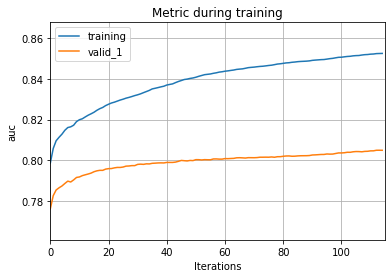

In [ ]:
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))
lgbm.plot_metric(model,'auc')


AUC= 0.8012152000720351
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    166783
           1       0.65      0.25      0.36     35529

    accuracy                           0.84    202312
   macro avg       0.76      0.61      0.63    202312
weighted avg       0.82      0.84      0.81    202312



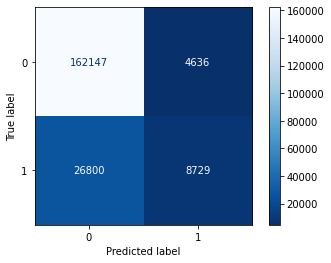

In [ ]:
print('AUC=',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
print(classification_report(y_test,model.predict(x_test)))
sklearn.metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

In [ ]:
pred=model.predict_proba(x_test)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

Best threshold is 0.37.
Confusion matrix :  [[154896  11887]
 [ 21092  14437]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90    166783
           1       0.55      0.41      0.47     35529

    accuracy                           0.84    202312
   macro avg       0.71      0.67      0.69    202312
weighted avg       0.82      0.84      0.83    202312

Best threshold is 0.26.
Confusion matrix :  [[141637  25146]
 [ 15065  20464]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88    166783
           1       0.45      0.58      0.50     35529

    accuracy                           0.80    202312
   macro avg       0.68      0.71      0.69    202312
weighted avg       0.82      0.80      0.81    202312



## HyperParameter tuning Grid Search

In [ ]:
# I prefer to use Optuna or other probabilistic search algorithms
# but for this project I am gonna use gridsearch.
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 
        'num_leaves': 64,
        'metric': 'auc'}

# Create parameters to search
grid_params = {'learning_rate': [0.025,0.05], 'n_estimators': [500],
              'num_leaves': [60], 'boosting_type': ['gbdt'], 
              'objective': ['binary'],
              'colsample_bytree': [0.6, 0.8], 
              'subsample': [0.6, 0.8],
              'reg_alpha': [0,1],
              'early_stopping_round':[50],
              }
mod = lgbm.LGBMClassifier(**params)

# Create and train the grid search
grid = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=4, n_jobs=-1,scoring='roc_auc')
grid.fit(x_train, y_train, eval_set=[(x_train,y_train),(x_test,y_test)])

In [ ]:
# Print the best parameters found
print(grid.best_estimator_)
print(grid.best_score_)

LGBMClassifier(colsample_bytree=0.6, early_stopping_round=50,
               learning_rate=0.05, metric='auc', n_estimators=500,
               num_leaves=60, objective='binary', reg_alpha=1, subsample=0.6)
0.8692537771426091


In [ ]:
best=lgbm.LGBMClassifier(colsample_bytree=0.5, early_stopping_round=50,
               learning_rate=0.05, metric='auc', n_estimators=1000,
               num_leaves=60, objective='binary', reg_alpha=1, subsample=0.5)
best.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)])

              precision    recall  f1-score   support

           0       0.87      0.96      0.92    166783
           1       0.65      0.35      0.46     35529

    accuracy                           0.85    202312
   macro avg       0.76      0.66      0.69    202312
weighted avg       0.84      0.85      0.84    202312

AUC= 0.8190034713534033
Best threshold is 0.40.
Confusion matrix :  [[155007  11776]
 [ 19139  16390]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91    166783
           1       0.58      0.46      0.51     35529

    accuracy                           0.85    202312
   macro avg       0.74      0.70      0.71    202312
weighted avg       0.84      0.85      0.84    202312

Best threshold is 0.28.
Confusion matrix :  [[144402  22381]
 [ 14235  21294]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    166783
           1       0.49      0.60      0.54     35529



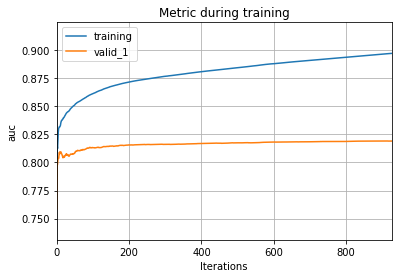

In [ ]:
print(classification_report(y_test,best.predict(x_test)))
pred=best.predict_proba(x_test)[:,1]
print('AUC=', roc_auc_score(y_test,pred))

threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))

score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_test,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_test,pred_class))
print(classification_report(y_test,pred_class))
lgbm.plot_metric(best,'auc')

**Next: LGB classifier with original features + target encoded binned numerical features**

#### Encoding Binned columns

In [ ]:
for col in data2.columns:
  if data2[col].dtype=='string' or data2[col].dtype=='object':
     data2[col]=data2[col].astype('category')
x_tr,x_tst,y_tr,y_tst=train_test_split(data2.drop(columns='MIS_Status'), data2['MIS_Status'], test_size=0.2, random_state=42)
print(x_tr.shape,x_tst.shape)

(647397, 40) (161850, 40)


In [ ]:
te=TargetEncoder(cols=bin_columns,handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.1)
te.fit(x_tr[bin_columns],y_tr)
x_tr[bin_columns]=te.transform(x_tr[bin_columns])
x_tst[bin_columns]=te.transform(x_tst[bin_columns])
print(print(x_tr.shape,x_tst.shape))
x_tr[bin_columns].head(3)

(647397, 40) (161850, 40)
None


,NoEmp_bin,CreateJob_bin,RetainedJob_bin,DisbursementGross_bin,BalanceGross_bin,GrAppv_bin,SBA_Appv_bin,Gr_Sb_diff_bin
362339,0.226485,0.156178,0.095876,0.090462,0.174817,0.091429,0.104206,0.114657
744820,0.164632,0.298897,0.247647,0.230384,0.174817,0.243006,0.292204,0.158252
763237,0.204848,0.156178,0.274675,0.199951,0.174817,0.243006,0.292204,0.158252


## Baseline gbdt model

In [ ]:
import lightgbm 
from lightgbm import LGBMClassifier

In [ ]:
mod=LGBMClassifier(metric='auc',n_estimators=1000,early_stopping=50)
mod.fit(x_tr,y_tr,eval_set=[(x_tst,y_tst)])

In [ ]:
print('Results for threshold 0.5')
print(classification_report(y_tst, mod.predict(x_tst)))
print('AUC score', roc_auc_score(y_tst, mod.predict_proba(x_tst)[:,1]))

print('Theshold search for best F1 score')
pred=mod.predict_proba(x_tst)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print(classification_report(y_tst,pred_class))

print('Theshold search for best weighted F1 score')
pred=mod.predict_proba(x_tst)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print(classification_report(y_tst,pred_class))

Results for threshold 0.5
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    133390
           1       0.67      0.32      0.43     28460

    accuracy                           0.85    161850
   macro avg       0.77      0.64      0.67    161850
weighted avg       0.83      0.85      0.83    161850

AUC score 0.8358487614215118
Theshold search for best F1 score
Best threshold is 0.28.
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    133390
           1       0.49      0.60      0.54     28460

    accuracy                           0.82    161850
   macro avg       0.70      0.73      0.72    161850
weighted avg       0.84      0.82      0.83    161850

Theshold search for best weighted F1 score
Best threshold is 0.39.
              precision    recall  f1-score   support

           0       0.89      0.93      0.91    133390
           1       0.59      0.45      0.51     28460

  

## Simple DART boosting Model

In [ ]:
from lightgbm.callback import early_stopping
mod_dart=LGBMClassifier(metric='auc',boosting_type='dart',objective='binary',
                        num_trees=2000, learning_rate=0.02,early_stopping=50)
mod_dart.fit(x_tr,y_tr,eval_set=[(x_tst,y_tst)])

In [ ]:
print('Results for threshold 0.5')
print(classification_report(y_tst, mod_dart.predict(x_tst)))
print('AUC score', roc_auc_score(y_tst, mod_dart.predict_proba(x_tst)[:,1]))

print('Theshold search for best F1 score')
pred=mod_dart.predict_proba(x_tst)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print(classification_report(y_tst,pred_class))

print('Theshold search for best weighted F1 score')
pred=mod_dart.predict_proba(x_tst)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print(classification_report(y_tst,pred_class))

Results for threshold 0.5
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    133390
           1       0.69      0.30      0.41     28460

    accuracy                           0.85    161850
   macro avg       0.78      0.63      0.67    161850
weighted avg       0.83      0.85      0.83    161850

AUC score 0.838484591518738
Theshold search for best F1 score
Best threshold is 0.28.
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    133390
           1       0.50      0.60      0.55     28460

    accuracy                           0.82    161850
   macro avg       0.71      0.74      0.72    161850
weighted avg       0.84      0.82      0.83    161850

Theshold search for best weighted F1 score
Best threshold is 0.37.
              precision    recall  f1-score   support

           0       0.89      0.93      0.91    133390
           1       0.59      0.47      0.52     28460

   

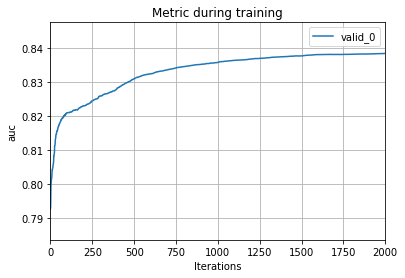

In [ ]:
lgbm.plot_metric(mod_dart)

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 
        'num_leaves': 64,
        'metric': 'auc'}

# Create parameters to search
grid_params = {'learning_rate': [0.05], 'n_estimators': [500],
              'num_leaves': [60,100], 
              'objective': ['binary'],
              'colsample_bytree': [0.5, 0.75], 
              'subsample': [0.5, 0.75],
              'early_stopping_round':[50],
               'max_depth':[-1,10]
              }
mod = lgbm.LGBMClassifier(**params)

# Create the grid
grid_orig = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=3, n_jobs=-1,scoring='roc_auc')
# Run the grid
grid_orig.fit(x_tr, y_tr, eval_set=[(x_tst,y_tst)])

# Print the best parameters found
print(grid_orig.best_score_)

In [ ]:
grid_orig.best_estimator_

LGBMClassifier(colsample_bytree=0.5, early_stopping_round=50,
               learning_rate=0.05, max_depth=10, metric='auc', n_estimators=500,
               num_leaves=100, objective='binary', subsample=0.5)

# Final Model

In [ ]:
best=lgbm.LGBMClassifier(colsample_bytree=0.5, early_stopping_round=50,
               learning_rate=0.03, max_depth=10, metric='auc', n_estimators=1000,
               num_leaves=100, objective='binary', subsample=0.5)
best.fit(x_tr,y_tr,eval_set=[(x_tst,y_tst)])

In [ ]:
print(classification_report(y_tst,best.predict(x_tst)))
print('AUC=',roc_auc_score(y_tst,best.predict_proba(x_tst)[:,1]))
pred=best.predict_proba(x_tst)[:,1]
threshold=np.linspace(0,1,400)
score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class,average='weighted')

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_tst,pred_class))
print(classification_report(y_tst,pred_class))

score={}
for t in threshold:
    pred_class=[1 if i>=t else 0 for i in pred]
    score[t]=f1_score(y_tst,pred_class)

best_threshold = max(score, key=score.get)
pred_class=[1 if i>=best_threshold else 0 for i in pred]
print('Best threshold is {:.2f}.'.format(best_threshold))
print('Confusion matrix : ', confusion_matrix(y_tst,pred_class))
print(classification_report(y_tst,pred_class))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92    133390
           1       0.68      0.33      0.44     28460

    accuracy                           0.85    161850
   macro avg       0.78      0.65      0.68    161850
weighted avg       0.84      0.85      0.83    161850

AUC= 0.8425663590514438
Best threshold is 0.38.
Confusion matrix :  [[124346   9044]
 [ 14952  13508]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91    133390
           1       0.60      0.47      0.53     28460

    accuracy                           0.85    161850
   macro avg       0.75      0.70      0.72    161850
weighted avg       0.84      0.85      0.84    161850

Best threshold is 0.28.
Confusion matrix :  [[117172  16218]
 [ 11352  17108]]
              precision    recall  f1-score   support

           0       0.91      0.88      0.89    133390
           1       0.51      0.60      0.55     28460



## Final Decision
I have chosen this model which is the result of the grid search because it gives us the highest AUC score among all previous models. The linear models generally results in poor preformance since the data have too many categorical features. (It would be better if we used F1 score for choosing the best model, because F1 score is more suitable for inbalanced data)

## Permutation Feature Importance

In [ ]:
# Initialize a list of results
results = []
auc_full_mod=roc_auc_score(y_tst,best.predict_proba(x_tst)[:,1])

# Iterate through each predictor
for predictor in x_tst:
    # Create a copy of x_test
    x_test_copy = x_tst.copy()
    
    # Scramble the values of the given predictor
    x_test_copy[predictor] = x_tst[predictor].sample(frac=1).values
    
    # Calculate the new MAE
    new_auc = roc_auc_score(y_tst, best.predict_proba(x_test_copy)[:,1])
    
    # Append the increase in MAE to the list of results 
    results.append({'pred': predictor,
                    'score': auc_full_mod - new_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)

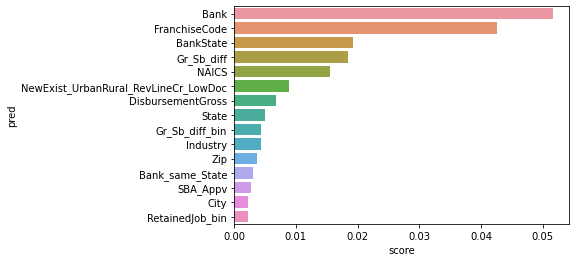

In [ ]:
import seaborn as sns
sns.barplot(data=resultsdf.head(15),x='score',y='pred')

Bank, Franchise Code, and BankState are the top 3 most important features.

## SHAP plots

In [ ]:
#!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(best)
shap_values = explainer.shap_values(x_tst)

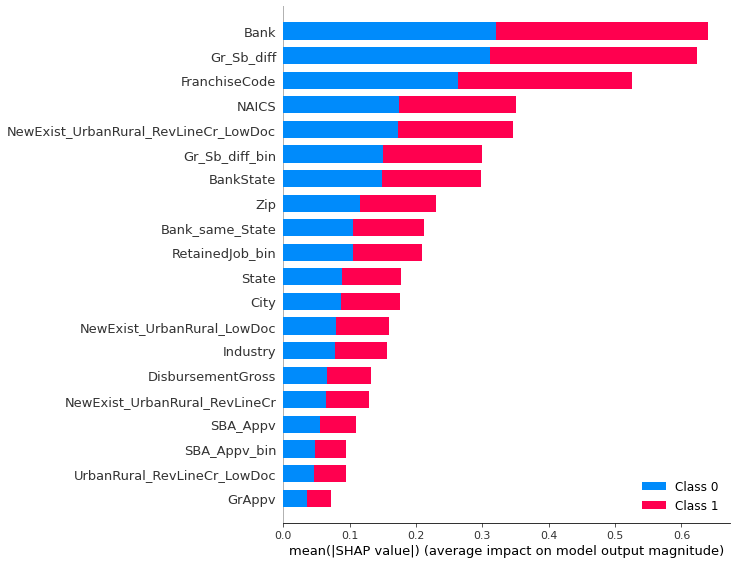

In [ ]:
shap.summary_plot(shap_values, x_tst)

According to shap summary plot, Bank, Gr_Sb_diff (difference between Gr_App and Sb_appv features), Franchise code and Naics are the top 4 contributors to the predictions.

**Residual Analysis**

In [ ]:
# Error analysis: Below, we first generate the logloss of each sample,
# and then look at the shap contribution of features to the most correct and incorrect N samples.
test_yhat = x_tst.copy()
test_yhat['MIS_Status']=y_tst
yhat = 'p_default'
resid = 'r_default'
test_yhat[yhat] = best.predict_proba(x_tst)[:,1]
y='MIS_Status'
test_yhat['s'] = 1
test_yhat.loc[test_yhat[y] == 0, 's'] = -1
# find logloss using predicted probability
test_yhat[resid] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                              ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

# add shap contributions to the data
cols_shap=[col+'_cont' for col in x_tst.columns]
test_yhat[cols_shap]=shap_values[1]

#sort the set by residuals in decreasing order
test_yhat = test_yhat.sort_values(by=resid, ascending=False).reset_index(drop=True)

# Define feature_values and shap values
shap_columns = cols_shap.copy()
ftr_columns = x_tst.columns.copy()
shap_contribs = test_yhat[cols_shap]
ftr_values =test_yhat[ftr_columns]

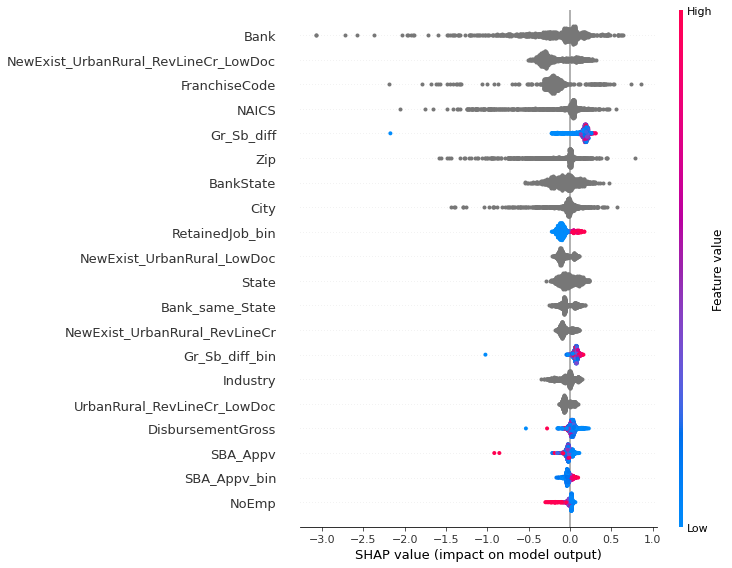

In [ ]:
# generate summary plot for top 1000 observations with largest positive residuals (class 1 predicted as 0)
shap.summary_plot(shap_values=shap_contribs.values[0:1000],
                  features=ftr_values[0:1000])

Composite 'NewExist_UrbanRural_RevLineCr_LowDoc' feature is the second top feature contributing to prob. predictions. Maybe deleting it from the model may give a better preformance, since it is not among top 4 overall contributors. So deleting it may not decrease overall model accuracy significantly but may improve accuracy for class 1 predictions.

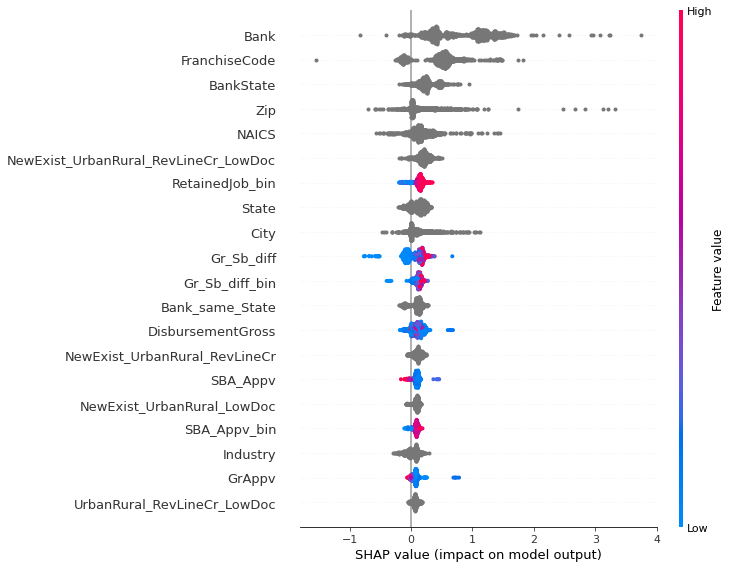

In [ ]:
# summary plot for bottom 100 observations with smallest negative residuals (class 0, predicted as 1)
shap.summary_plot(shap_values=shap_contribs.values[-1000:],
                  features=ftr_values[-1000:])

### Local SHAP Plots


In [ ]:
# create a function to get local shap plot
def ind_shap_plot(explainer, combined_df, shap_columns, ftr_columns, index):
  return shap.force_plot(explainer.expected_value[1], combined_df[shap_columns].iloc[index,:].values,
                         combined_df[ftr_columns].iloc[index,:],link="logit")

#### Case 1: actual 1 predicted as 0

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,0) # highest residual

In [ ]:
test_yhat[test_yhat['Gr_Sb_diff']==0][y].mean()

0.011464670098268601

Gr_Sb_diff is the main negative contributor to the predicted value. As we can see in the above cell, only 1 percent of observations with Gr_Sb_diff=0 is within '0' class. So the model can not capture this small percent.


In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,1) # 2nd highest residual

Bank and Naics is the main negative contributors. Gr_Sb_diff is the only positive contributor, but it is not significant

#### Case 2: actual 0 predicted as 1

In [ ]:
print('Index ',len(x_tst)-1,'\n', test_yhat[[y,yhat]].iloc[len(x_tst)-1],'\n')
print('Index ',len(x_tst)-2,'\n', test_yhat[[y,yhat]].iloc[len(x_tst)-2],'\n')


Index  161849 
 MIS_Status    0.000000
p_default     0.945406
Name: 161849, dtype: float64 

Index  161848 
 MIS_Status    0.000000
p_default     0.933551
Name: 161848, dtype: float64 



In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns, len(x_tst)-1) 

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns, len(x_tst)-2) 

In both of the above two observations, the 'Bank' and 'FranchiseCode' are the main two features increasing the probaility prediction. There are no negative contributors.

#### Case 3: Actual 0 predicted as 0

In [ ]:
print('Index 40000:','\n',test_yhat[[y,yhat]].iloc[40000],'\n')
print('Index 41000:','\n',test_yhat[[y,yhat]].iloc[41000])

Index 40000: 
 MIS_Status    0.000000
p_default     0.002653
Name: 40000, dtype: float64 

Index 41000: 
 MIS_Status    0.000000
p_default     0.004108
Name: 41000, dtype: float64


In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,40000)

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,41000)

In both examples, value of the 'Gr_Sb_diff' is the main contributor decreasing the probability of default. FranchiseCode and NAICS are the two main negative contributors. When Gr_Sb_diff is 0, the model will mostly predict low probability of default, because almost 99% percent of observations with this value are in class 0.

#### Case 4: 1 predicted as 1

In [ ]:
print('Index 26928	:','\n',test_yhat[[y,yhat]].iloc[26928],'\n')
print('Index 28459	:','\n',test_yhat[[y,yhat]].iloc[28459])

Index 26928	: 
 MIS_Status    1.000000
p_default     0.800025
Name: 26928, dtype: float64 

Index 28459	: 
 MIS_Status    1.0000
p_default     0.9805
Name: 28459, dtype: float64


In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,26928)

In [ ]:
shap.initjs()
ind_shap_plot(explainer, test_yhat, shap_columns, ftr_columns,28459)

Bank and Franchise code are the main features contributing to prediction positively, and there are no other signifcant contributors.

# Train and Scoring Functions

Here, we create two seperate functions for training the model and generating final prediction submission. Train model includes all the steps done above from preprocessing to model training. And scoring function generates predictions for the unseen data using the objects created during training.

In [ ]:
def sba_train(data):
    """
    Function to score input dataset.
    
    Input: dataset in Pandas DataFrame format
    Output: Python list of labels in the same order as input records
    
    Flow:
        - Load artifacts
        - Transform dataset
        - Score dataset
        - Return labels
    
    """
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from copy import deepcopy
    from sklearn.linear_model import LogisticRegression
    import lightgbm as lgbm
    from category_encoders import TargetEncoder
    import pickle
    
    '''Clean and feature engineer'''
    def clean_data(data):
        value_to_fill={}
        for col in data.columns:
            if data[col].dtype=='object':
                value_to_fill[col]='Missing'
            else:
                value_to_fill[col]=0
        data.fillna(value=value_to_fill,inplace=True)

        Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

        for col in Columns:
            for char in ['$',',']:
                data[col] = data[col].str.replace(char,'')
            data[col]=data[col].astype(float)

        #LowDoc and RevLineCr can only be 'Y' or 'N', i.e., yes or no.
        for col in ['LowDoc' , 'RevLineCr']:
            data[col]=data[col].agg(lambda x: 'Missing' if x not in ['N','Y'] else x)

        # NAICS code must be 6 digit code: replace smaller digits with 0.
        data['NAICS']=data['NAICS'].agg(lambda x: x if len(str(x))==6 else 0)

        # Franchise code 0 and 1 means 'NO Franchise'
        data['FranchiseCode']=data['FranchiseCode'].agg(lambda x: 1 if x==1 else x)
        
        # Convert NAICS, FranchaiseCode, Zip,'NewExist' and 'UrbanRural' into object type
        for col in ['FranchiseCode','NAICS','Zip','NewExist','UrbanRural']:
            data[col]=data[col].astype(object)

        #Convert MIS into binary
        MIS_dict={'P I F': 0, 'CHGOFF': 1, 'Missing':0}
        data['MIS_Status'].replace(MIS_dict,inplace=True)
        return(data)

    def feature_engineer(data):
        ''' Creates two new features: Industry and Montly_disumbersement.
            Input: Cleaned SBA Dataframe
            Output: Dataframe with feature engineered columns
        '''
        industry_codes=['11','21','22','23','31','32','33','42','44','45','48','49','51',
                        '52','53','54','55','56','61','62','71','72','81','0']
        industry_dict={'11':'Agriculture, forestry, fishing and hunting',
            '21':'Mining, quarrying, and oil and gas extraction',
            '22':'Utilities',
            '23':'Construction',
            '31':'Manufacturing',
            '32':'Manufacturing',
            '33':'Manufacturing',
            '42':'Wholesale trade',
            '44':'Retail trade',
            '45':'Retail trade',
            '48':'Transportation and warehousing',
            '49':'Transportation and warehousing',
            '51':'Information',
            '52':'Finance and insurance',
            '53':'Real estate and rental and leasing',
            '54':'Professional, scientific, and technical services',
            '55':'Management of companies and enterprises',
            '56':'Administrative and support and waste management and remediation services',
            '61':'Educational services',
            '62':'Health care and social assistance',
            '71':'Arts, entertainment, and recreation',
            '72':'Accommodation and food services',
            '81':'Other services (except public administration) 92 Public administration',
            '0':'undefined'}
        # Function to create Industry column from NAICS columns
        def add_Industry_col(data):
            data['Industry']=data['NAICS'].astype('string')
            data['Industry']=data['Industry'].apply(lambda x: x[:2] if x[:2] in industry_codes else  x=='0' )
            data['Industry'].replace(industry_dict,inplace=True)
            return data
        return add_Industry_col(data)

    def bin_numerical_cols(data, drop=True,number_of_bins=40):
        '''
        Create bins for numerical variables based on quantiles
        
        Inputs:
            data:  Cleaned and feature engineered SBA dataframe
            drop:  True or False/ True drops binned numerical columns
            number_of_bins: Maximum number of quantile bins
        
        Output: Dataframe with bin columns
        '''
        #This can also be done with if condition to determine numerical columns
        numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                          'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']
        bin_columns=[]
        binned_col=[]
        bins_for_cols={}
        for col in numerical_cols:
            bins=[np.percentile(data[col].values,i) for i in np.linspace(2.5,97.5,number_of_bins-1)]
            bins=np.concatenate([[-np.inf],bins,[np.inf]])
            bins_for_cols[col]=bins
            data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop')
            data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop').astype('object')
            binned_col.append(col)
            bin_columns.append(col+'_bin')
        if drop==True:
            data.drop(columns=binned_col,inplace=True)
        return data,bin_columns,bins_for_cols

    #Apply defined functions and create new features
    data2=clean_data(data)
    data2=feature_engineer(data2)
    data2['Gr_Sb_diff']=data2['GrAppv']-data2['SBA_Appv']
    data2['Bank_same_State']=data2['State']==data2['BankState']
    data2['Bank_same_State']=data2['Bank_same_State'].astype('category')
    for col in ['NewExist','UrbanRural', 'RevLineCr', 'LowDoc']:
        data2[col]=data2[col].astype('string')

    data2['NewExist_UrbanRural']=data2['NewExist'].astype('string')+'_'+data2['UrbanRural'].astype('string')
    data2['NewExist_RevLineCr']=data2['NewExist'].astype('string')+'_'+data2['RevLineCr'].astype('string')
    data2['NewExist_LowDoc']=data2['NewExist'].astype('string')+'_'+ data2[ 'LowDoc'].astype('string')
    data2['UrbanRural_RevLineCr']=data2['UrbanRural'].astype('string')+'_'+data2['RevLineCr'].astype('string')
    data2['UrbanRural_LowDoc']=data2['UrbanRural'].astype('string')+'_'+data2['LowDoc'].astype('string')
    data2['RevLineCr_UrbanRural']=data2['RevLineCr'].astype('string')+'_'+data2['LowDoc'].astype('string')

    # 3-way combinations
    data2['NewExist_UrbanRural_RevLineCr']=data2['NewExist_UrbanRural']+'_'+data2['RevLineCr']
    data2['NewExist_UrbanRural_LowDoc']=data2['NewExist_UrbanRural']+'_'+data2['LowDoc']
    data2['NewExist_RevLineCr_LowDoc']=data2['NewExist_RevLineCr']+'_'+data2['LowDoc']
    data2['UrbanRural_RevLineCr_LowDoc']=data2['UrbanRural_RevLineCr']+'_'+data2['LowDoc']

    # 4-way combination
    data2['NewExist_UrbanRural_RevLineCr_LowDoc']=data2['NewExist_UrbanRural_RevLineCr']+'_'+data2['LowDoc']    
   
    data2, bin_columns, bins_for_cols =bin_numerical_cols(data2,drop=False,number_of_bins=40)
    numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                          'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']
    for col in data2.columns:
       if data2[col].dtype=='string' or data2[col].dtype=='object':
          data2[col]=data2[col].astype('category')

    '''Train model and encoders'''
    y_tr = data2['MIS_Status']
    x_tr = data2.drop(columns=['MIS_Status'])

    te=TargetEncoder(cols=bin_columns,handle_missing='value',handle_unknown='value', min_samples_leaf=5, smoothing=0.1)
    te.fit(x_tr[bin_columns],y_tr)
    x_tr[bin_columns]=te.transform(x_tr[bin_columns])
  
    clf=lgbm.LGBMClassifier(colsample_bytree=0.5, early_stopping_round=50,
               learning_rate=0.03, max_depth=10, metric='auc', n_estimators=1000,
               num_leaves=100, objective='binary', subsample=0.5,verbosity=0)
    clf.fit(x_tr,y_tr,eval_set=[(x_tr,y_tr)])

    sba_lgbm_file = open("sba_lgbm_model.pkl", "wb")
    sba_encoders_file = open("sba_encoders.pkl", "wb")
    pickle.dump(obj=clf, file=sba_lgbm_file)
    pickle.dump(obj=te, file=sba_encoders_file)
    
    sba_lgbm_file.close()
    sba_encoders_file.close()
    return clf

In [ ]:
def sba_score(data):
    """
    Function to score input dataset.
    
    Input: dataset in Pandas DataFrame format
    Output: Python list of labels in the same order as input records
    
    Flow:
        - Load artifacts
        - Transform dataset
        - Score dataset
        - Return labels
    
    """
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    from copy import deepcopy
    from sklearn.linear_model import LogisticRegression
    import lightgbm as lgbm
    from category_encoders import TargetEncoder
    import pickle
    
    '''Clean and feature engineer'''
    def clean_data(data):
        value_to_fill={}
        for col in data.columns:
            if data[col].dtype=='object':
                value_to_fill[col]='Missing'
            else:
                value_to_fill[col]=0
        data.fillna(value=value_to_fill,inplace=True)

        Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

        for col in Columns:
            for char in ['$',',']:
                data[col] = data[col].str.replace(char,'')
            data[col]=data[col].astype(float)

        #LowDoc and RevLineCr can only be 'Y' or 'N', i.e., yes or no.
        for col in ['LowDoc' , 'RevLineCr']:
            data[col]=data[col].agg(lambda x: 'Missing' if x not in ['N','Y'] else x)

        # NAICS code must be 6 digit code: replace smaller digits with 0.
        data['NAICS']=data['NAICS'].agg(lambda x: x if len(str(x))==6 else 0)

        # Franchise code 0 and 1 means 'NO Franchise'
        data['FranchiseCode']=data['FranchiseCode'].agg(lambda x: 1 if x==1 else x)
        
        # Convert NAICS, FranchaiseCode, Zip,'NewExist' and 'UrbanRural' into object type
        for col in ['FranchiseCode','NAICS','Zip','NewExist','UrbanRural']:
            data[col]=data[col].astype(object)

        #Convert MIS into binary
        MIS_dict={'P I F': 0, 'CHGOFF': 1, 'Missing':0}
        data['MIS_Status'].replace(MIS_dict,inplace=True)
        return(data)

    def feature_engineer(data):
        ''' Creates two new features: Industry and Montly_disumbersement.
            Input: Cleaned SBA Dataframe
            Output: Dataframe with feature engineered columns
        '''
        industry_codes=['11','21','22','23','31','32','33','42','44','45','48','49','51',
                        '52','53','54','55','56','61','62','71','72','81','0']
        industry_dict={'11':'Agriculture, forestry, fishing and hunting',
            '21':'Mining, quarrying, and oil and gas extraction',
            '22':'Utilities',
            '23':'Construction',
            '31':'Manufacturing',
            '32':'Manufacturing',
            '33':'Manufacturing',
            '42':'Wholesale trade',
            '44':'Retail trade',
            '45':'Retail trade',
            '48':'Transportation and warehousing',
            '49':'Transportation and warehousing',
            '51':'Information',
            '52':'Finance and insurance',
            '53':'Real estate and rental and leasing',
            '54':'Professional, scientific, and technical services',
            '55':'Management of companies and enterprises',
            '56':'Administrative and support and waste management and remediation services',
            '61':'Educational services',
            '62':'Health care and social assistance',
            '71':'Arts, entertainment, and recreation',
            '72':'Accommodation and food services',
            '81':'Other services (except public administration) 92 Public administration',
            '0':'undefined'}
        # Function to create Industry column from NAICS columns
        def add_Industry_col(data):
            data['Industry']=data['NAICS'].astype('string')
            data['Industry']=data['Industry'].apply(lambda x: x[:2] if x[:2] in industry_codes else  x=='0' )
            data['Industry'].replace(industry_dict,inplace=True)
            return data
        return add_Industry_col(data)

    def bin_numerical_cols(data, drop=False):
        '''
        Create bins for numerical variables based on quantiles
        
        Inputs:
            data:  Cleaned and feature engineered SBA dataframe
            drop:  True or False/ True drops binned numerical columns
            number_of_bins: Maximum number of quantile bins
        
        Output: Dataframe with bin columns
        '''
        #This can also be done with if condition to determine numerical columns
        numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                          'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']
        bins_for_cols={'BalanceGross': [-np.inf,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                              0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                              0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                              0.,   0.,   0.,   0.,   0.,   0.,   0.,  np.inf],
        'CreateJob':    [-np.inf,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                            0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   2.,   2.,
                            2.,   3.,   4.,   5.,   7.,  10.,  18.,  np.inf],
        'DisbursementGross': [      -np.inf,    8280.15,   10000.  ,   15000.  ,   20000.  ,
                                    24500.  ,   25000.  ,   30000.  ,   34377.4 ,   37300.  ,
                                    42000.  ,   49041.  ,   50000.  ,   50000.  ,   57150.2 ,
                                    63370.  ,   70000.  ,   75000.  ,   83589.7 ,   92087.85,
                                  100000.  ,  100000.  ,  110000.  ,  123000.  ,  135000.  ,
                                  150000.  ,  151000.  ,  172000.  ,  194000.  ,  210000.  ,
                                  238000.  ,  260000.  ,  300000.  ,  333000.  ,  380000.  ,
                                  442000.  ,  500000.  ,  616000.  ,  763000.  , 1000000.  ,
                                  np.inf],
        'GrAppv':     [ -np.inf,    7000.,   10000.,   12000.,   15000.,   20000.,
                            25000.,   25000.,   25000.,   30000.,   35000.,   40000.,
                            45000.,   50000.,   50000.,   50000.,   56000.,   65000.,
                            75000.,   80000.,   90000.,  100000.,  100000.,  103500.,
                          120000.,  136000.,  150000.,  155000.,  180000.,  200000.,
                          225000.,  250000.,  285390.,  322000.,  367000.,  428000.,
                          500000.,  601000.,  750000., 1000000.,      np.inf],
        'Gr_Sb_diff':  [ -np.inf,      0.  ,      0.  ,      0.  ,   1500.  ,   2500.  ,
                                3840.  ,   5000.  ,   5000.  ,   6000.  ,   7500.  ,   8000.  ,
                              10000.  ,  10000.  ,  11662.1 ,  12500.  ,  12500.  ,  14000.  ,
                              15000.  ,  17000.  ,  18000.  ,  20000.  ,  22500.  ,  25000.  ,
                              25000.  ,  25000.  ,  30000.  ,  35550.  ,  38700.  ,  45000.  ,
                              50000.  ,  50000.  ,  58750.  ,  67000.  ,  75000.  ,  88000.  ,
                              105000.  , 125000.  , 162500.  , 240152.55,       np.inf],
        'NoEmp':    [-np.inf,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,
                                2.,   2.,   2.,   3.,   3.,   3.,   3.,   4.,   4.,   4.,   5.,
                                5.,   5.,   6.,   6.,   7.,   8.,   8.,  10.,  10.,  12.,  13.,
                              15.,  17.,  20.,  25.,  30.,  40.,  60.,  np.inf],
        'RetainedJob':  [-np.inf,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
                              0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
                              1.,   1.,   2.,   2.,   2.,   3.,   3.,   3.,   4.,   5.,   5.,
                              6.,   7.,   9.,  11.,  14.,  20.,  31.,  np.inf],
        'SBA_Appv':     [    -np.inf,   4250. ,   5000. ,   7500. ,  10000. ,  12059. ,
                        12500. ,  12750. ,  16000. ,  17500. ,  21250. ,  25000. ,
                        25000. ,  25000. ,  31040. ,  36540. ,  40000. ,  45000. ,
                        50000. ,  52105. ,  61200. ,  69930. ,  76500. ,  83300. ,
                        90000. , 104000. , 115500. , 127500. , 136000. , 152852.1,
                        175000. , 195300. , 225000. , 257000. , 299457.9, 346500. ,
                        407182.2, 496125. , 627000. , 750000. ,      np.inf]}
        bin_columns=[]
        binned_col=[]
        for col in numerical_cols:
            bins=bins_for_cols[col]
            data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop')
            data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop').astype('object')
            binned_col.append(col)
            bin_columns.append(col+'_bin')
        if drop==True:
            data.drop(columns=binned_col,inplace=True)
        return data,bin_columns

    #Apply defined functions and create new features
    data2=clean_data(data)
    data2=feature_engineer(data2)
    data2['Gr_Sb_diff']=data2['GrAppv']-data2['SBA_Appv']
    data2['Bank_same_State']=data2['State']==data2['BankState']
    data2['Bank_same_State']=data2['Bank_same_State'].astype('category')
    for col in ['NewExist','UrbanRural', 'RevLineCr', 'LowDoc']:
        data2[col]=data2[col].astype('string')

    data2['NewExist_UrbanRural']=data2['NewExist'].astype('string')+'_'+data2['UrbanRural'].astype('string')
    data2['NewExist_RevLineCr']=data2['NewExist'].astype('string')+'_'+data2['RevLineCr'].astype('string')
    data2['NewExist_LowDoc']=data2['NewExist'].astype('string')+'_'+ data2[ 'LowDoc'].astype('string')
    data2['UrbanRural_RevLineCr']=data2['UrbanRural'].astype('string')+'_'+data2['RevLineCr'].astype('string')
    data2['UrbanRural_LowDoc']=data2['UrbanRural'].astype('string')+'_'+data2['LowDoc'].astype('string')
    data2['RevLineCr_UrbanRural']=data2['RevLineCr'].astype('string')+'_'+data2['LowDoc'].astype('string')

    # 3-way combinations
    data2['NewExist_UrbanRural_RevLineCr']=data2['NewExist_UrbanRural']+'_'+data2['RevLineCr']
    data2['NewExist_UrbanRural_LowDoc']=data2['NewExist_UrbanRural']+'_'+data2['LowDoc']
    data2['NewExist_RevLineCr_LowDoc']=data2['NewExist_RevLineCr']+'_'+data2['LowDoc']
    data2['UrbanRural_RevLineCr_LowDoc']=data2['UrbanRural_RevLineCr']+'_'+data2['LowDoc']

    # 4-way combination
    data2['NewExist_UrbanRural_RevLineCr_LowDoc']=data2['NewExist_UrbanRural_RevLineCr']+'_'+data2['LowDoc']    
   
    data2, bin_columns=bin_numerical_cols(data2,drop=False)
    numerical_cols=['NoEmp','CreateJob','RetainedJob','DisbursementGross',
                          'BalanceGross','GrAppv','SBA_Appv','Gr_Sb_diff']
    for col in data2.columns:
       if data2[col].dtype=='string' or data2[col].dtype=='object':
          data2[col]=data2[col].astype('category')

    '''Download model and encoders'''
    y_tst = data2['MIS_Status']
    x_tst = data2.drop(columns=['MIS_Status'])

    sba_lgbm_file = open("sba_lgbm_model.pkl", "rb")
    sba_encoders_file = open("sba_encoders.pkl", "rb")
    clf = pickle.load(file=sba_lgbm_file)
    te = pickle.load(file=sba_encoders_file)

    x_tst[bin_columns]=te.transform(x_tst[bin_columns])

    pred=clf.predict_proba(x_tst)[:,1]
    sba_lgbm_file.close()
    sba_encoders_file.close()

    print('AUC=',roc_auc_score(y_tst,pred))
    
    threshold=np.linspace(0,1,400)
    score={}
    for t in threshold:
        pred_class=[1 if i>=t else 0 for i in pred]
        score[t]=f1_score(y_tst,pred_class,average='weighted')

    best_threshold = max(score, key=score.get)
    pred_class=[1 if i>=best_threshold else 0 for i in pred]
    return  pred_class

##  model without Term Feature

In this case we have tried to make the problem harder by removing the most important feature, i.e., "Term".

In [ ]:
data=pd.read_csv('SBA_loans_project_2.zip')
train,test= train_test_split(data,test_size=0.2,random_state=42)
sba_train(train)
pred=sba_score(test)

AUC= 0.8407418570140015


In [ ]:
print(classification_report(test['MIS_Status'],pred))
print(confusion_matrix(test['MIS_Status'],pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91    133390
           1       0.60      0.46      0.52     28460

    accuracy                           0.85    161850
   macro avg       0.74      0.70      0.72    161850
weighted avg       0.84      0.85      0.84    161850

[[124499   8891]
 [ 15247  13213]]


# Train with Original data (Term Feature)

In [ ]:
# Here I use the original data that also includes the "Term" feature.\
# You can see that the performance increases significantly. From 0.85 to 0.95 F1 score.
data=pd.read_csv('SBA_loans_project_1.zip')
train,test= train_test_split(data,test_size=0.2,random_state=42)
sba_train(train)
pred=sba_score(test)

In [ ]:
print(classification_report(test['MIS_Status'],pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97    133414
           1       0.87      0.86      0.86     28436

    accuracy                           0.95    161850
   macro avg       0.92      0.92      0.92    161850
weighted avg       0.95      0.95      0.95    161850

